<a href="https://colab.research.google.com/github/kmatusz/btc/blob/master/model_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

### Load dataset

Functions for loading images and masks from folder - compatible type with keras 

In [ ]:
def load_images(path = 'data/keras_input/train/'):
    images_names = [x for x in os.listdir(path) if 'x' in x]
    masks_names = [x for x in os.listdir(path) if 'y' in x]
    images_names.sort()
    masks_names.sort()
    
    images_list = []
    masks_list = []
    for i in range(len(images_names)):
        img = image.load_img(os.path.join(path, images_names[i]), target_size=(256, 256),color_mode='grayscale')
        img_mask = image.load_img(os.path.join(path, masks_names[i]), target_size=(256, 256),color_mode='grayscale')
        images_list.append(img)
        masks_list.append(img_mask)
        
    images_arrays_list = [image.img_to_array(img) for img in images_list]
    images_arrays_list = [img_array.reshape((1,) + img_array.shape) for img_array in images_arrays_list]
    images_np = np.concatenate(images_arrays_list)
    
    masks_arrays_list = [image.img_to_array(img) for img in masks_list]
    masks_arrays_list = [img_array.reshape((1,) + img_array.shape) for img_array in masks_arrays_list]
    masks_np = np.concatenate(masks_arrays_list)
    return (images_np, masks_np)

Create data generators - perform augmentation on the image

In [ ]:
datagen = image.ImageDataGenerator(
    rotation_range=180, # In degrees, how much to rotate the image
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, # Spłaszczenie
    zoom_range=0.01, # Zoom +/-
    horizontal_flip=True, 
    rescale = 1./255,
    fill_mode='nearest' # How to fill newly created pixels
)

datagen_val = image.ImageDataGenerator(
    rescale = 1./255
)

Function for creating flow (python generator) of data to keras

In [ ]:
def create_data_flow(datagen, images_np, masks_np, batch_size = 1, seed = 2):
    img_flow = datagen.flow(images_np, batch_size=batch_size,seed=seed)
    mask_flow = datagen.flow(masks_np, batch_size=batch_size,seed=seed)
    return zip(img_flow, mask_flow)

Create train and validation datasets - train2 catalog contains manually preprocessed images - black backgroud greyed out. It gives much better performance than without this preprocessing.

In [ ]:
!ls

sample_data


In [ ]:
# Train
images_np, masks_np = load_images('data/keras_input/train2/')
flow_train = create_data_flow(datagen, images_np, masks_np)

FileNotFoundError: ignored

In [ ]:

!ls

sample_data


In [ ]:
# Validation 
images_np_val, masks_np_val = load_images('data/keras_input/validation/')
flow_validation = create_data_flow(datagen_val, images_np_val, masks_np_val, batch_size = 16)

Sanity checks - if the images and masks are of the same kind

In [ ]:
a,b = next(flow_train)

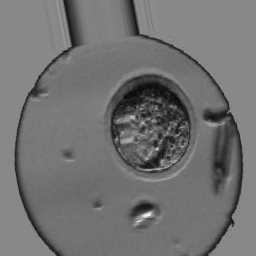

In [ ]:
Image.fromarray((a[0,:,:,0]*255).astype(np.uint8),'P')

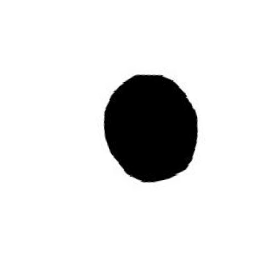

In [ ]:
Image.fromarray((b[0,:,:,0]*255).astype(np.uint8),'P')

### Modeling

Below model doesn't make any sense, but setting up the pipeline is the same as in unet

In [ ]:
# stupid model but to check if works
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()
model.add(layers.Conv2D(1, (1, 1), activation='relu',input_shape=(256,256,1)))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 1)       2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(flow_train,validation_data=flow_validation, steps_per_epoch = 100, epochs = 1,validation_steps=1)

100/100 [==============================] - 1s 13ms/step - loss: 1.1113 - acc: 0.1016 - val_loss: 1.8843 - val_acc: 0.1143


In [ ]:
from tensorflow.keras import layers

img_size = (256,256)
num_classes = 2

In [ ]:
from tensorflow.keras import Input, backend, Model

In [ ]:
# Tests of keras functional API
# l_input = Input(shape = (1,250,250,3), name = 'input')
# l1 = layers.Conv2D(3, (3, 3), activation="relu", padding="same",name = 'l1')(l_input)
# l2_1 = layers.Conv2D(3, (3, 3), activation="relu", padding="same", name = 'l2_1')(l1)
# l2_2 = layers.Conv2D(3, (3, 3), activation="relu", padding="same", name='l2_2')(l1)
# l3 = layers.concatenate([l2_1, l2_2], axis=-1, name = 'l3')
# l4 = layers.Conv2D(3, (3, 3), activation="relu", padding="same", name='l4')(l3)
# a = Model(l_input, l4)
# a.summary()

In [ ]:
img_size_target = (256)
input_layer = Input((img_size_target, img_size_target, 1))
start_neurons = 32

In [ ]:
# convolution blocks - conv -> conv -> pooling -> dropout
conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
pool1 = layers.Dropout(0.25)(pool1)

conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
pool2 = layers.Dropout(0.5)(pool2)

conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
pool3 = layers.MaxPooling2D((2, 2))(conv3)
pool3 = layers.Dropout(0.5)(pool3)

conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
pool4 = layers.MaxPooling2D((2, 2))(conv4)
pool4 = layers.Dropout(0.5)(pool4)


# Middle layers - conv -> conv (no pooling, no dropout)
convm = 3
convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

# Final layers
# 1. Get output from middle of conv part
# 2. Conv2DTranspose 
# 3. concatenate with convolution layer output
# 4. Dropout
# 5. Conv
# 6. conv
deconv4= layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = layers.concatenate([deconv4, conv4])

uconv4 = layers.Dropout(0.5)(uconv4)
uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

deconv3= layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = layers.concatenate([deconv3, conv3])
uconv3 = layers.Dropout(0.5)(uconv3)
uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

deconv2= layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = layers.concatenate([deconv2, conv2])
uconv2 = layers.Dropout(0.5)(uconv2)
uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

deconv1= layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = layers.concatenate([deconv1, conv1])
uconv1 = layers.Dropout(0.5)(uconv1)
uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

In [ ]:
model2 = Model(input_layer, output_layer)

In [ ]:
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_2[0][0]                   
_______________________________________________________________________________________

In [ ]:
# Callbacks
from tensorflow.keras import callbacks
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss',
                                  patience=1,),
    callbacks.ModelCheckpoint(filepath='models/model2_32neurons_1000steps_20epochs_gray.h5',
                                    monitor='val_loss',
                                    save_best_only=True,)]
# model.fit(x, y,epochs=10,batch_size=32,,validation_data=(x_val, y_val))

In [ ]:
model2.compile(optimizer="rmsprop", loss="binary_crossentropy")

# Train the model, doing validation at the end of each epoch.
epochs = 20
steps_per_epoch = 1000
history = model2.fit(flow_train, validation_data=flow_validation, 
                     validation_steps = 1,
                     epochs=epochs,
                     steps_per_epoch=steps_per_epoch,
                     callbacks=callbacks_list)

Epoch 1/20
1000/1000 [==============================] - 107s 107ms/step - loss: 1085.1825 - val_loss: 0.8260
Epoch 2/20
1000/1000 [==============================] - 100s 100ms/step - loss: 0.1450 - val_loss: 0.2315
Epoch 3/20
1000/1000 [==============================] - 98s 98ms/step - loss: 0.0939 - val_loss: 0.4022


32 neurons, 1000 steps per epoch runs about 1:30 min per epoch

Generate predictions

In [ ]:
a, b = next(flow_train)
preds = model2.predict(a)

In [ ]:
preds.shape

(1, 256, 256, 1)

In [ ]:
preds[0,:,:,0]#.astype(np.uint8)

array([[0.99921596, 0.99994934, 0.99999   , ..., 0.99999464, 0.9999907 ,
        0.9996643 ],
       [0.99994063, 0.9999981 , 0.99999976, ..., 0.99999976, 0.9999999 ,
        0.9999676 ],
       [0.99994195, 0.99999774, 0.99999976, ..., 1.        , 1.        ,
        0.9999869 ],
       ...,
       [0.99960834, 0.9999858 , 0.99999535, ..., 0.9999995 , 0.9999988 ,
        0.99991906],
       [0.9992975 , 0.9999666 , 0.9999907 , ..., 0.9999926 , 0.99998915,
        0.9995952 ],
       [0.9928215 , 0.99935955, 0.99963415, ..., 0.9998667 , 0.9997774 ,
        0.99740845]], dtype=float32)

Original image

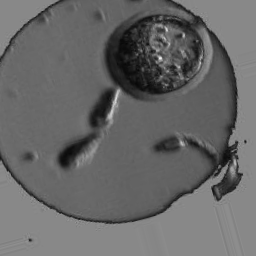

In [ ]:
Image.fromarray((a[0,:,:,0]*255).astype(np.uint8),'P')

Original mask

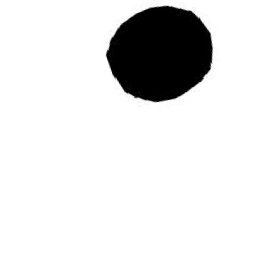

In [ ]:
Image.fromarray((b[0,:,:,0]*255).astype(np.uint8),'P')

Predicted mask

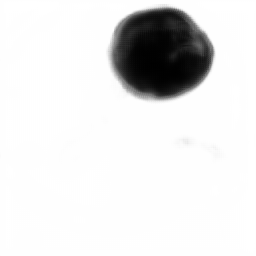

In [ ]:
Image.fromarray((preds[0,:,:,0]*255).astype(np.uint8),'P')

Predicted mask with thresholding

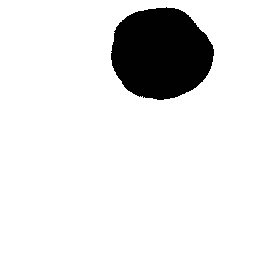

In [ ]:
Image.fromarray((np.where(preds[0,:,:,0]*255>170, 255, 1)).astype(np.uint8),'P')

Original image with predicted mask

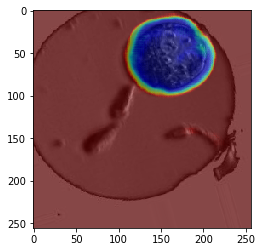

In [ ]:
plt.imshow(a[0,:,:,0]*255, cmap='gray')
plt.imshow(preds[0,:,:,0]*255, cmap='jet', alpha=0.5)

Mask and predicted

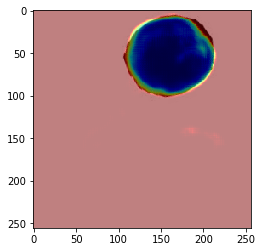

In [ ]:
plt.imshow(b[0,:,:,0]*255, cmap='gray')
plt.imshow(preds[0,:,:,0]*255, cmap='jet', alpha=0.5)

#### Loading pretrained model

In [ ]:
from tensorflow import keras

In [ ]:
model_loaded = keras.models.load_model('models/model2_32neurons_1000steps_20epochs_gray.h5')

In [ ]:
# Validation 
images_np_val, masks_np_val = load_images('data/keras_input/validation3/')
flow_validation = create_data_flow(datagen_val, images_np_val, masks_np_val, batch_size = 16)

Generate predictions

In [ ]:
a, b = next(flow_validation)
preds = model_loaded.predict(a)

In [ ]:
preds.shape

(16, 256, 256, 1)

In [ ]:
preds[0,:,:,0]#.astype(np.uint8)

array([[0.66348785, 0.6836088 , 0.6899717 , ..., 0.69152784, 0.7071309 ,
        0.68458194],
       [0.6954484 , 0.71282125, 0.69953257, ..., 0.68062615, 0.71798146,
        0.7052632 ],
       [0.7004112 , 0.7335476 , 0.70236397, ..., 0.6782142 , 0.70091486,
        0.71991587],
       ...,
       [0.9618603 , 0.9774072 , 0.9968033 , ..., 0.9998405 , 0.9979008 ,
        0.9982186 ],
       [0.9029825 , 0.9367351 , 0.98913556, ..., 0.9994302 , 0.99246323,
        0.9957726 ],
       [0.835875  , 0.9153798 , 0.9653554 , ..., 0.99963003, 0.99740815,
        0.9886402 ]], dtype=float32)

Original image

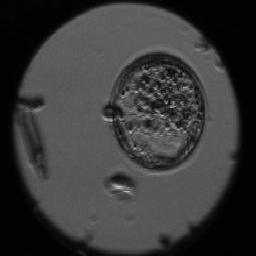

In [ ]:
Image.fromarray((a[0,:,:,0]*255).astype(np.uint8),'P')

Original mask

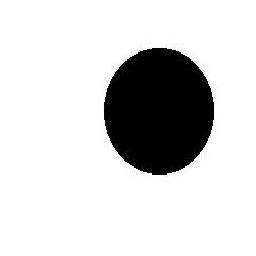

In [ ]:
Image.fromarray((b[0,:,:,0]*255).astype(np.uint8),'P')

Predicted mask

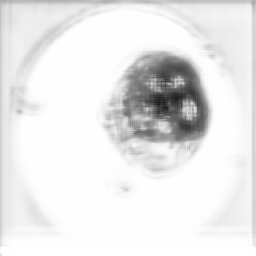

In [ ]:
Image.fromarray((preds[0,:,:,0]*255).astype(np.uint8),'P')

Predicted mask with thresholding

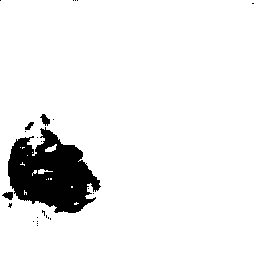

In [ ]:
Image.fromarray((np.where(preds[0,:,:,0]*255>170, 255, 1)).astype(np.uint8),'P')

Original image with predicted mask

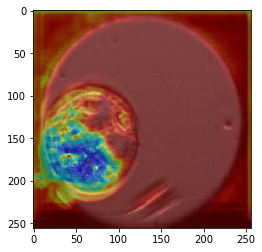

In [ ]:
plt.imshow(a[0,:,:,0]*255, cmap='gray')
plt.imshow(preds[0,:,:,0]*255, cmap='jet', alpha=0.5)

Mask and predicted

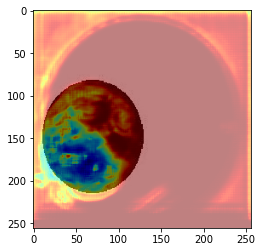

In [ ]:
plt.imshow(b[0,:,:,0]*255, cmap='gray')
plt.imshow(preds[0,:,:,0]*255, cmap='jet', alpha=0.5)